On colab using a Python 3 kernel, you should be all set with running in one cell (takes a while, but gives you visual feedback about progress, differently from spacy.cli)

In [0]:
! rm -rf *
! pip install word2number
! pip install num2words
! python -m spacy download en_core_web_lg
! pip install pyldavis


  Created wheel for word2number: filename=word2number-1.1-cp36-none-any.whl size=5588 sha256=20dc9442bd037f5196252b1081d85740b859ee1228c4b86bd8779af9508fd6f0
  Stored in directory: /root/.cache/pip/wheels/46/2f/53/5f5c1d275492f2fce1cdab9a9bb12d49286dead829a4078e0e
Successfully built word2number
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
from word2number.w2n import word_to_num
word_to_num("second")

ValueError: ignored

After executing, comment the line and restart the runtime.


```
# !python -m spacy download en_core_web_lg
```



In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# import pickle
# with open('./drive/My Drive/Colab Notebooks/ifixit_docs.pkl', 'rb') as f:
#    docs=pickle.load( f)
# f.close()
# with open('./drive/My Drive/Colab Notebooks/ifixit_data.pkl', 'rb') as f:
#    data=pickle.load( f)
# f.close()

In [0]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import string
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict
import nltk
from nltk.corpus import wordnet
import requests
import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy.matcher import Matcher 
from spacy.tokens import Span , Doc, Token
import seaborn as sns
from num2words import num2words

import pyLDAvis.sklearn

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import nltk

In [0]:
nlp = spacy.load('en_core_web_lg')
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
question = ["what", "when", "how", "?"]
nltk.download("wordnet")
matcher = Matcher(nlp.vocab)
for q in question :
  if q in stopwords:
    stopwords.remove(q)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
urls = [
        "https://www.gutenberg.org/ebooks/29444",
        "https://www.gutenberg.org/ebooks/31428",
        "https://www.gutenberg.org/ebooks/4908",
        "https://www.gutenberg.org/ebooks/33504",
        "https://www.gutenberg.org/ebooks/39017",
        "https://www.gutenberg.org/ebooks/37157",
        "https://www.gutenberg.org/ebooks/15207",
        "https://www.gutenberg.org/ebooks/10773",
        "https://www.gutenberg.org/ebooks/31624",
        "https://www.gutenberg.org/ebooks/5192",
        "https://www.gutenberg.org/ebooks/40030",
        "https://www.gutenberg.org/ebooks/50992",
        "https://www.gutenberg.org/ebooks/50880",
        "https://www.gutenberg.org/ebooks/36525",
        "https://www.gutenberg.org/ebooks/47167",
        "https://www.gutenberg.org/ebooks/47464",
        "https://www.gutenberg.org/ebooks/33397",
        "https://www.gutenberg.org/ebooks/29782",
        "https://www.gutenberg.org/ebooks/32857",
        "https://www.gutenberg.org/ebooks/26262",
        ]

urls = ['http://www.gutenberg.org/cache/epub/'+ u.split("/")[-1]+"/pg"+u.split("/")[-1] +".txt"  for u in urls]

In [0]:
for u in urls:
  docs = [requests.get(u).text for u in urls]

In [0]:
def spacy_tokenizer(sentence):
    sentence = sentence.lower()
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens
parser =  English()

In [0]:
def process_docs(docs):

  ndocs = []
  for i in tqdm(range(len(docs))):
    doc = docs[i]
    doc.replace("\n"," ")
    doc.replace("  "," ")
    ndocs.append( spacy_tokenizer(doc))
  vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
  ndocs_vec = vectorizer.fit_transform(ndocs)
  tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
  tfidf_transformer.fit(ndocs_vec)
  tf_idf_vector=tfidf_transformer.transform(ndocs_vec)
  return ndocs, ndocs_vec, vectorizer, tfidf_transformer, tf_idf_vector


<input>:9: DeprecationWarning: invalid escape sequence \-
<input>:9: DeprecationWarning: invalid escape sequence \-
<input>:9: DeprecationWarning: invalid escape sequence \-
<input>:9: DeprecationWarning: invalid escape sequence \-
<input>:9: DeprecationWarning: invalid escape sequence \-
<input>:9: DeprecationWarning: invalid escape sequence \-
<input>:9: DeprecationWarning: invalid escape sequence \-
<input>:9: DeprecationWarning: invalid escape sequence \-
<input>:9: DeprecationWarning: invalid escape sequence \-
<input>:9: DeprecationWarning: invalid escape sequence \-
<input>:9: DeprecationWarning: invalid escape sequence \-
<input>:9: DeprecationWarning: invalid escape sequence \-
<input>:9: DeprecationWarning: invalid escape sequence \-
<input>:9: DeprecationWarning: invalid escape sequence \-
<input>:9: DeprecationWarning: invalid escape sequence \-
<input>:9: DeprecationWarning: invalid escape sequence \-
<input>:9: DeprecationWarning: invalid escape sequence \-
<input>:9: Dep

In [0]:
ndocs, ndocs_vec, vectorizer, tfidf_transformer, tf_idf_vector =process_docs(docs)

In [0]:

def sentence_weight( tfidf, sentence):
    sentence_weight = 0
    sentence_processed = spacy_tokenizer(sentence)
    sentence_processed = sentence_processed.split(" ")
    for word in sentence_processed:
            if word in question : 
              sentence_weight += -1000
            else:
              sentence_weight += tfidf[word]
    sentence_weight =  sentence_weight/ len(sentence_processed)
    return sentence_weight

In [0]:
def determine_weights(tfidf, lines):
  sentence_weights=[]


  for line in lines :
    try :
      sentence_weights.append(sentence_weight( tfidf, line))
    except :
      sentence_weights.append(0)
  return np.array(sentence_weights), lines

In [0]:
SEL_FR = 0.4
# para_text  = "What is common in liquids and gases? Unlike a solid, a fluid has no definite shape of its own. Solids and liquids have a fixed volume, whereas a gas fills the entire volume of its container. We have learnt in the previous chapter that the volume of solids can be changed by stress. The volume of solid, liquid or gas depends on the stress or pressure acting on it. When we talk about fixed volume of solid or liquid, we mean its volume under atmospheric pressure. The difference between gases and solids or liquids is that for solids or liquids the change in volume due to change of external pressure is rather small. In other words solids and liquids have much lower compressibility as compared to gases. Shear stress can change the shape of a solid keeping its volume fixed. The key property of fluids is that they offer very little resistance to shear stress; their shape changes by application of very small shear stress. The shearing stress of fluids is about million times smaller than that of solids. "
para_text = "We are familiar with air current and water current. We know that flowing water constitute water current in rivers. Similarly, if the electric charge flows through a conductor (for example, through a metallic wire), we say that there is an electric current in the conductor. In a torch, we know that the cells (or a battery, when placed in proper order) provide flow of charges or an electric current through the torch bulb to glow. We have also seen that the torch gives light only when its switch is on. What does a switch do? A switch makes a conducting link between the cell and the bulb. A continuous and closed path of an electric current is called an electric circuit. Now, if the circuit is broken anywhere (or the switch of the torch is turned off), the current stops flowing and the bulb does not glow. How do we express electric current? Electric current is expressed by the amount of charge flowing through a particular area in unit time. In other words, it is the rate of flow of electric charges. In circuits using metallic wires, electrons constitute the flow of charges. However, electrons were not known at the time when the phenomenon of electricity was first observed. So, electric current was considered to be the flow of positive charges and the direction of flow of positive charges was taken to be the direction of electric current. Conventionally, in an electric circuit the direction of electric current is taken as opposite to the direction of the flow of electrons, which are negative charges. The SI unit of electric charge is coulomb (C), which is equivalent to the charge contained in nearly 6 × 1018 electrons. (We know that an electron possesses a negative charge of 1.6 × 10–19 C.) The electric current is expressed by a unit called ampere (A), named after the French scientist, Andre-Marie Ampere (1775–1836). One ampere is constituted by the flow of one coulomb of charge per second, that is, 1 A = 1 C/1 s. Small quantities of current are expressed in milliampere (1 mA = 10–3 A) or in microampere (1 µA = 10–6 A). An instrument called ammeter measures electric current in a circuit. It is always connected in series in a circuit through which the current is to be measured. Figure 12.1 shows the schematic diagram of a typical electric circuit comprising a cell, an electric bulb, an ammeter and a plug key. Note that the electric current flows in the circuit from the positive terminal of the cell to the negative terminal of the cell through the bulb and ammeter What makes the electric charge to flow? Let us consider the analogy of flow of water. Charges do not flow in a copper wire by themselves, just as water in a perfectly horizontal tube does not flow. If one end of the tube is connected to a tank of water kept at a higher level, such that there is a pressure difference between the two ends of the tube, water flows out of the other end of the tube. For flow of charges in a conducting metallic wire, the gravity, of course, has no role to play; the electrons move only if there is a difference of electric pressure – called the potential difference – along the conductor. This difference of potential may be produced by a battery, consisting of one or more electric cells. The chemical action within a cell generates the potential difference across the terminals of the cell, even when no current is drawn from it. When the cell is connected to a conducting circuit element, the potential difference sets the charges in motion in the conductor and produces an electric current. In order to maintain the current in a given electric circuit, the cell has to expend its chemical energy stored in it."
doc =  nlp(para_text)
sents = [sent for sent in doc.sents]
lines = [b.text  for b in [sent for sent in doc.sents]]
paras = [spacy_tokenizer(l) for l in lines]
paras_vec = vectorizer.transform(paras)
paras_tfidf = tfidf_transformer.transform(paras_vec)
feature_names = vectorizer.get_feature_names()
para_tfidf = paras_tfidf[0].T.toarray().flatten() 
tfidf = defaultdict(int,zip(feature_names,para_tfidf))
sent_wt , lines = determine_weights(tfidf, lines)
arg_mx_sent_wt = np.argsort(-sent_wt)
n_sents =  int( SEL_FR * len(sent_wt))
for i in range(n_sents) :
  print(lines[arg_mx_sent_wt[i]], " | ", sent_wt[arg_mx_sent_wt[i]])


We are familiar with air current and water current.  |  0.4898979485566356
We know that flowing water constitute water current in rivers.  |  0.23328473740792172
It is always connected in series in a circuit through which the current is to be measured.  |  0.16329931618554522
An instrument called ammeter measures electric current in a circuit.  |  0.13608276348795434
So, electric current was considered to be the flow of positive charges and the direction of flow of positive charges was taken to be the direction of electric current.  |  0.12561485860426555
A continuous and closed path of an electric current is called an electric circuit.  |  0.11664236870396086
Electric current is expressed by the amount of charge flowing through a particular area in unit time.  |  0.09072184232530289
Let us consider the analogy of flow of water.  |  0.08164965809277261
In order to maintain the current in a given electric circuit, the cell has to expend its chemical energy stored in it.  |  0.0816496580

 
*In other words solids and liquids have much lower compressibility as compared to gases.  text*



*   In other words solids and liquids have much lower compressibility as compared to gases. 
*   In other words solids and liquids have much higher compressibility as compared to gases. 
*    In other words solids and gas have much lower compressibility as compared to liquids. 
*   In other words solids and gas have much higher compressibility as compared to liquids. 


*The volume of solid, liquid or gas depends on the stress or pressure acting on it.*
1.   The volume of solid, liquid or gas depends on the stress or pressure acting on it.
2.   The volume of solid, liquid or gas doesnt depends on the stress or pressure acting on it.
3. The volume of solid, liquid or gas depends on the stress or force acting on it.
4. The weight of solid, liquid or gas depends on the stress or pressure acting on it.


*The difference between gases and solids or liquids is that for solids or liquids the change in volume due to change of external pressure is rather small.*
1.   The difference between gases and solids or liquids is that for solids or liquids the change in volume due to change of external pressure is rather small.
2.   The similarity between gases and solids or liquids is that for solids or liquids the change in volume due to change of external pressure is rather small.
3.   The difference between gases and solids or liquids is that for solids or liquids the change in weight due to change of external pressure is rather big.
4.   The difference between gases and solids or liquids is that for solids or liquids the change in volume due to change of internal pressure is rather small.


*Solids and liquids have a fixed volume, whereas a gas fills the entire volume of its container.
1.   Solids and liquids have a fixed volume, whereas a gas fills the entire volume of its container.
2.   Solids and liquids have a flexible  volume, whereas a gas fills the entire volume of its container.
3.   Solids and gas have a fixed weight, whereas a liquid fills the entire volume of its container.
4.    Solids and liquids have a fixed volume, whereas a gas fills the half volume of its container.








In [0]:
displacy.render(doc, style="ent", jupyter=True)
displacy.render(nlp("An instrument called ammeter measures electric current in a circuit."), style="dep", jupyter=True)


In [0]:
sent = next(nlp("An instrument called ammeter measures electric current in a circuit.").sents)
sent = next(nlp("A continuous and closed path of an electric current is called an electric circuit.").sents)
for tok in sent:
  if tok.pos_ == "ADJ":
    print(tok.text, tok.prob, tok.dep_, tok.cluster, [s.text for s in find_similar(tok,offset=7)])
sent.root

173
continuous -12.275837898254395 amod 1831 ['predetermined', 'partial', 'corresponding', 'incessant', 'considerable', 'relentless', 'simulated', 'proper', 'permanent', 'broad']
0
closed -10.28239917755127 conj 2858 []
25
electric -11.099902153015137 amod 1463 ['outdoor', 'sanitary', 'decorative', 'optical', 'filtration', 'marine', 'agricultural', 'audio', 'organic', 'raw']
25
electric -11.099902153015137 amod 1463 ['outdoor', 'sanitary', 'decorative', 'optical', 'filtration', 'marine', 'agricultural', 'audio', 'organic', 'raw']


called

In [0]:
def find_similar(tok, offset = 10):
  querry = [ w for w in tok.vocab if w.cluster  == tok.cluster \
            and w.prob > -15 and w.has_vector and w.is_lower \
            and  w.is_alpha and len(w.text)>2 and w.text != tok.text ]#and w.pos  == tok.pos]
  similar = sorted(querry, key=lambda w: tok.similarity(w), reverse=True)
  print(len(querry))
  # return similar[offset:offset+10]
  return similar[offset:offset+10]
tok = nlp('It is an ammeter')[3]
similar = find_similar(tok)

[s.text for s in similar]
# s.suffix_ , s.text


5671


['preamp',
 'amps',
 'speedo',
 'phono',
 'leds',
 'condenser',
 'unplugging',
 'blinker',
 'unplug',
 'soldered']

In [0]:
def get_entities(doc):
  ## chunk 1
  subjects = []
  objects =  []
  relations = []
  sentences = []
  prefix = ""
  modifier = ""
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 
  matcher.add("sub_obj_relation", None, pattern)
  matches = matcher(doc)
  sents = doc.sents
  for sent in sents :
    subject_ = ""
    object_ =""
    relation = ""
    for match in matches :
      if sent.start <= match[1] and sent.end >= match[2] : 
        relation  =  doc[match[1] :  match[2]].text
    for i,  tok in enumerate(sent) :
      if tok.dep_ != "punct":
        
        if tok.dep_ == "compound":
          prefix = tok.text
          
          if i > 0  and  prv_tok.dep_ == "compound":
            prefix = prv_tok_text + " "+ tok.text
        if tok.dep_.endswith("mod") == True:
          modifier = tok.text
          if i > 0  and prv_tok.dep_ == "compound":
            modifier = prv_tok_text + " "+ tok.text
        if tok.dep_.find("subj") == True:
          subject_ = modifier +" "+ prefix + " "+ tok.text
          prefix = ""
          modifier = ""
          prv_tok_dep = ""
          prv_tok_text = ""     
        if tok.dep_.find("obj") == True:
          object_ = modifier +" "+ prefix +" "+ tok.text
        prv_tok = tok
    if len(relation)>0 : 
      relations.append(relation)
      subjects.append(subject_.strip())
      objects.append(object_.strip())
      sentences.append(sent.text)
  matcher.remove("sub_obj_relation")
  return pd.DataFrame({"subject": subjects, "object":objects, "relation":relations, 'sentence': sentences})


In [0]:
df = get_entities(doc)
for i in range(len(df)):
  print(df["subject"][i], " | ",df["object"][i], " | ",df["relation"][i], " | ",df["sentence"][i])

In [0]:
from nltk.corpus import wordnet
synonyms = [] 
antonyms = [] 
  
for syn in wordnet.synsets("solids", 'n'): 
    for l in syn.lemmas(): 
        synonyms.append(l.name()) 
        if l.antonyms(): 
            antonyms.append(l.antonyms()[0].name()) 
  
print(set(synonyms)) 
print(set(antonyms))

{'solid_state', 'solid', 'solidness'}
set()


In [0]:
def detect_noun(doc):
    n = []
    noun =[]
    propn =[]
    for token in doc :
      if token.pos_ == "NOUN" and token.is_alpha and not token.lemma_ in n:
        n.append(token.lemma_)
        noun.append(token)
      if token.pos_  == "PROPN" and token.is_alpha:
        propn.append(token)
    return noun, propn

noun, propn = detect_noun(doc)


# for i  in range(len(noun)) : 
#   for j in range(i, len(noun)) :
#     mat[i,j] = noun[i].similarity(noun[j])
#     mat[j,i] =  mat[i,j]



3


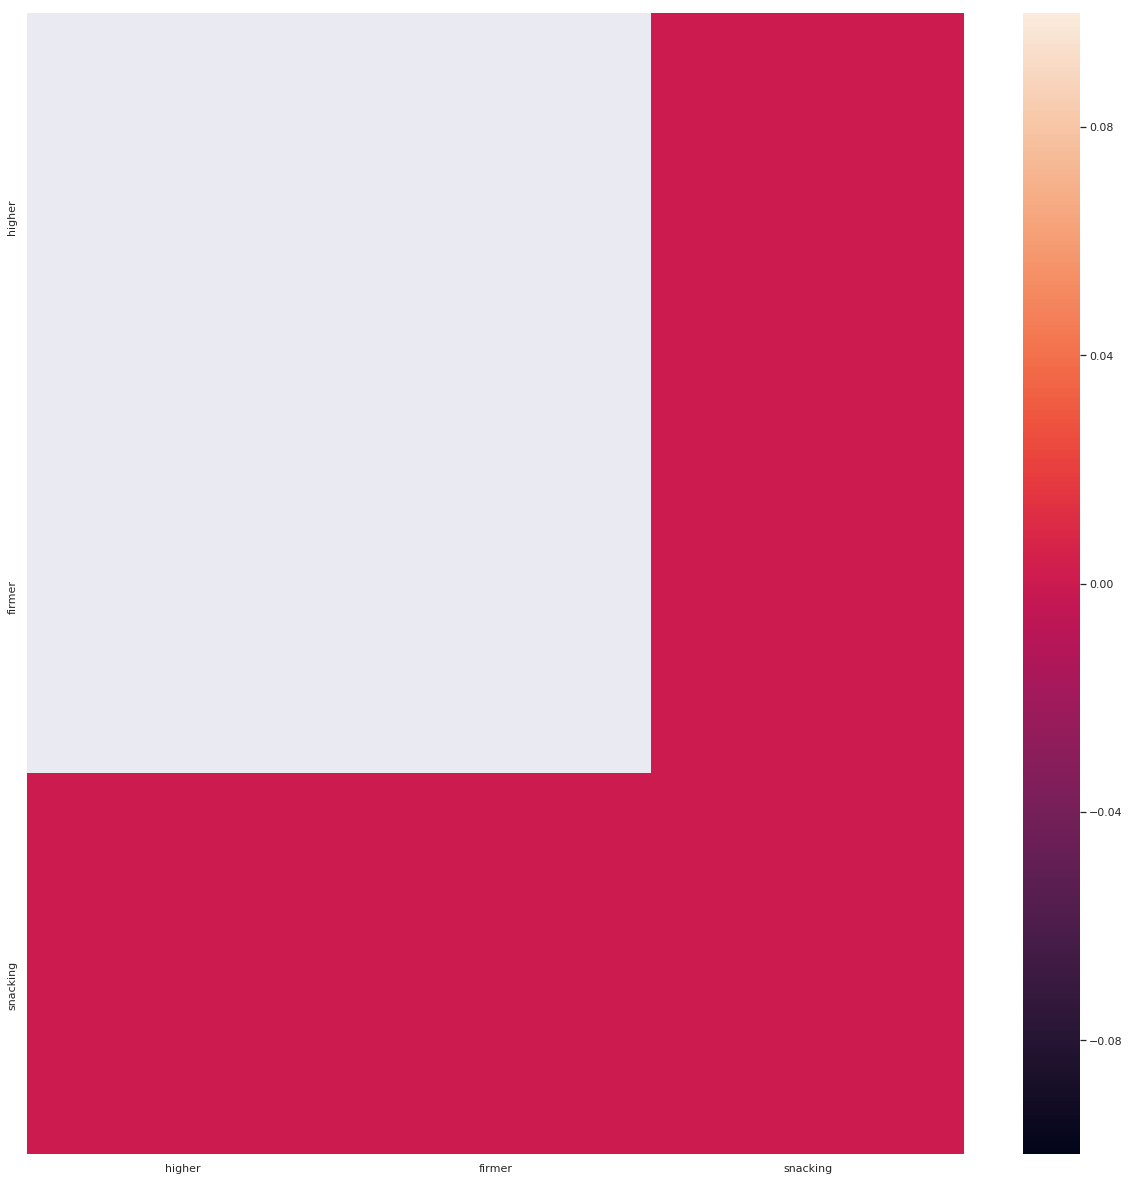

In [0]:
tok = nlp("I had lower than average stat today")[2]
similar  =  find_similar(tok, offset=0)
mat =  np.zeros((len(similar), len(similar)))
for i  in range(len(similar)) : 
  syni = wordnet.synsets(similar[i].lower_, 'a')
  if syni :
    for j in range(i, len(similar)) :
      
      synj = wordnet.synsets(similar[j].lower_, 'a')
      if synj :
        mat[i,j] = syni[0].lch_similarity(synj[0])
        mat[j,i] =  mat[i,j]
n = [n.text for n in similar]
df_noun =  pd.DataFrame(mat, index =n, columns=n )
sns.set(rc={'figure.figsize':(21,21)})
sns.heatmap(df_noun, annot=False)

In [0]:
def root_negation(span):
  # find all verbs in the span
  # if more than one verb select:
  # 1. non have am be is form
  # 2. select root verb
  # check if previus ofr next token is negative
  # for the sentence negation on the verb
  aux_verb = [ 'am', 'are', 'is', 'was', 'were', 'being', 'been', 'can', 'could', 'dare', 'do' ,'does', 'did', 'have', 'has', 'had', 'having', 'may', 'might', 'must', 'need', 'ought', 'shall', 'should', 'will', 'would']

  aux_verb_neg = [ 'am not', 'are not', 'is not', 'was not', 'were not', 'not being', 'not been', 'can not', 'could not', 'dare not', 'do not' ,'doesnt', 'did not', 'dont have', 'doesnt have', 'had not', 'not having', 'may not', 'might not', 'must not', 'need not', 'ought not', 'shall not', 'should not', 'will not', 'would not']
  map_aux = {aux_verb[i] : aux_verb_neg[i] for i in range(len(aux_verb))}
  root  =  span.root
  if root.pos_ != "VERB":
    return span.text ,  False
  distr =  [tok.text for tok in span]
  negated = False
  if root.i > span.start :
    prev = span[root.i -1 - sent.start]
    if prev.lower_ == "not" or prev.lower_ == "no":
      negated = True
      del distr[root.i -1 - sent.start]
      return " ".join(distr) , True
    elif   prev.suffix_ =="'nt" or prev.suffix_ =="nt" :
      negated  = True
      distr[root.i -1 - sent.start] = prev.text[:-len(prev.suffix_)]
      return " ".join(distr) , True
  if  root.i < span.end :
    after = span[root.i +1 - sent.start]
    if after.lower_ == "not" or after.lower_ == "no":
      negated = True
      del distr[root.i +1 - sent.start]
      return " ".join(distr) , True
    elif   after.suffix_ =="'nt" or after.suffix_ =="nt" :
      negated  = True
      distr[root.i +1 - sent.start] = after.text[:-len(after.suffix_)]
      return " ".join(distr) , True
  if root.lower_ in aux_verb :
    distr[root.i -span.start] =map_aux[ root.lower_ ]
  else :
    if span[root.i -1-span.start].lower_ in aux_verb :
      distr[root.i -1 -span.start] =  map_aux[span[root.i -1-span.start].lower_ ]
    elif root.tag_ =="VBN" : 
      distr.insert(root.i -span.start ,  "not")
    else:
      distr.insert(root.i -span.start ,  "do not")
    print("do not", root.lower_,span[root.i -1-span.start].lower_ )
  return  " ".join(distr) , True

In [0]:
i = 0 
for sent in doc.sents:
  print(i , sent,"|",sent.root, sent.root.tag_ )
  print(i ,  root_negation(sent)[0])
  print("-----------------------------")
  # print(sent[0].lower_ == "we")
  i+=1

0 We are familiar with air current and water current. | are VBP
0 We are not familiar with air current and water current .
-----------------------------
1 We know that flowing water constitute water current in rivers. | know VBP
do not know we
1 We do not know that flowing water constitute water current in rivers .
-----------------------------
2 Similarly, if the electric charge flows through a conductor (for example, through a metallic wire), we say that there is an electric current in the conductor. | say VBP
do not say we
2 Similarly , if the electric charge flows through a conductor ( for example , through a metallic wire ) , we do not say that there is an electric current in the conductor .
-----------------------------
3 In a torch, we know that the cells (or a battery, when placed in proper order) provide flow of charges or an electric current through the torch bulb to glow. | know VBP
do not know we
3 In a torch , we do not know that the cells ( or a battery , when placed in p

In [0]:
def is_number(x):
    if type(x) == str:
        x = x.replace(',', '')
    try:
        float(x)
    except:
        return False
    return True

def text2int (textnum, numwords={}):
    units = [
        'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight',
        'nine', 'ten', 'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen',
        'sixteen', 'seventeen', 'eighteen', 'nineteen',
    ]
    tens = ['', '', 'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety']
    scales = ['hundred', 'thousand', 'million', 'billion', 'trillion']
    ordinal_words = {'first':1, 'second':2, 'third':3, 'fifth':5, 'eighth':8, 'ninth':9, 'twelfth':12}
    ordinal_endings = [('ieth', 'y'), ('th', '')]

    if not numwords:
        numwords['and'] = (1, 0)
        for idx, word in enumerate(units): numwords[word] = (1, idx)
        for idx, word in enumerate(tens): numwords[word] = (1, idx * 10)
        for idx, word in enumerate(scales): numwords[word] = (10 ** (idx * 3 or 2), 0)

    textnum = textnum.replace('-', ' ')

    current = result = 0
    curstring = ''
    onnumber = False
    lastunit = False
    lastscale = False

    def is_numword(x):
        if is_number(x):
            return True
        if word in numwords:
            return True
        return False

    def from_numword(x):
        if is_number(x):
            scale = 0
            increment = int(x.replace(',', ''))
            return scale, increment
        return numwords[x]

    for word in textnum.split():
        if word in ordinal_words:
            scale, increment = (1, ordinal_words[word])
            current = current * scale + increment
            if scale > 100:
                result += current
                current = 0
            onnumber = True
            lastunit = False
            lastscale = False
        else:
            for ending, replacement in ordinal_endings:
                if word.endswith(ending):
                    word = "%s%s" % (word[:-len(ending)], replacement)

            if (not is_numword(word)) or (word == 'and' and not lastscale):
                if onnumber:
                    # Flush the current number we are building
                    curstring += repr(result + current) + " "
                curstring += word + " "
                result = current = 0
                onnumber = False
                lastunit = False
                lastscale = False
            else:
                scale, increment = from_numword(word)
                onnumber = True

                if lastunit and (word not in scales):                                                                                                                                                                                                                                         
                    # Assume this is part of a string of individual numbers to                                                                                                                                                                                                                
                    # be flushed, such as a zipcode "one two three four five"                                                                                                                                                                                                                 
                    curstring += repr(result + current)                                                                                                                                                                                                                                       
                    result = current = 0                                                                                                                                                                                                                                                      

                if scale > 1:                                                                                                                                                                                                                                                                 
                    current = max(1, current)                                                                                                                                                                                                                                                 

                current = current * scale + increment                                                                                                                                                                                                                                         
                if scale > 100:                                                                                                                                                                                                                                                               
                    result += current                                                                                                                                                                                                                                                         
                    current = 0                                                                                                                                                                                                                                                               

                lastscale = False                                                                                                                                                                                                              
                lastunit = False                                                                                                                                                
                if word in scales:                                                                                                                                                                                                             
                    lastscale = True                                                                                                                                                                                                         
                elif word in units:                                                                                                                                                                                                             
                    lastunit = True

    if onnumber:
        curstring += repr(result + current)

    return curstring

In [0]:
def cardinality_change(span, ordinal =True):
  ratio_sel = np.concatenate((np.arange(0.1,0.25,0.5), np.arange(5, 20, 5)))
  ratio = ratio_sel[np.random.choice(len(ratio_sel),3,replace =  False)]
  sent = span.sent
  distr =  [tok.text for tok in sent]
  tok =  span[0]
  prev=  sent[tok.i -1 -sent.start]
  if prev.lower_ in ["figure", "fig", "graph" ,"table"] :
    return [sent.text] , [], False
  try : 
    num = int(text2int(span.lower_))
    
  except :
    try :
      num = float(span.lower_.split(" ")[0])
    except:
      return [sent.text] ,[], False
  answers = []

  dist_num  = num *ratio
  if num > 10 :
    dist_num =dist_num.astype('int32')
  else :
    dist_num = [round(d,2) for d  in  dist_num] 
  if tok.is_alpha:
    distr_txt= [num2words(int(f), ordinal=ordinal) for f in dist_num]
  else:
    distr_txt = [str(f) for f in dist_num]
  for r in distr_txt:
    text = distr.copy()
    del text[ent.start - sent.start: ent.end- sent.start]
    # print(r,distr, text)
    text.insert(tok.i-sent.start , r)
    answers.append(" ".join(text))
  
  # matcher.remove("cardinal")
  return answers ,distr_txt , True

In [0]:
def entity_substitution(span):
  sent = span.sent
  distr = [tok.text  for tok in sent]
  tok =  span[0]
  similar = np.array(find_similar( tok, offset = 2))
  # print(similar)
  if len(similar) >  3 :
    # print(len(similar),np.random.choice(len(similar),3, replace= False))
    #  ratio_sel[np.random.choice(len(ratio_sel),3,replace =  False)]
    dist_ent = similar[np.random.choice(len(similar),3, replace= False)]
    
    distraction =[]
    for i in range(len(dist_ent)) :
      distr[tok.i -sent.start] = dist_ent[i].text.title()
      distraction.append(" ".join(distr))
      # print(" ".join(distr))
    return distraction ,[e.text for e  in  dist_ent] ,  True
  return [sent.text] , [] , False

In [0]:
for i, ent in   enumerate(doc.ents):
  ent_typ = ent[0].ent_type_
  status =  False
  if ent_typ in ['ORG' , "NORP" , "GPE", "LOC"] :
    distraction , _, status  =  entity_substitution(ent)

  elif ent_typ in ['MONEY' , "CARDINAL" , "GPE", "LOC", "QUANTITY"] :
    distraction ,_, status  =  cardinality_change(ent, ordinal =False)
  elif ent_typ in [ "ORDINAL"] :
    distraction ,_, status  =  cardinality_change(ent, ordinal =True)
  if status :
    print("{}. {} ##### | {} | {}".format(i, ent.sent, ent.text,ent_typ) )
    print(i, distraction)
    print("-------------")



SI
46
0. The SI unit of electric charge is coulomb (C), which is equivalent to the charge contained in nearly 6 × 1018 electrons. ##### | SI | ORG
0 ['The Dee unit of electric charge is coulomb ( C ) , which is equivalent to the charge contained in nearly 6 × 1018 electrons .', 'The Modelo unit of electric charge is coulomb ( C ) , which is equivalent to the charge contained in nearly 6 × 1018 electrons .', 'The Bei unit of electric charge is coulomb ( C ) , which is equivalent to the charge contained in nearly 6 × 1018 electrons .']
-------------
1. The SI unit of electric charge is coulomb (C), which is equivalent to the charge contained in nearly 6 × 1018 electrons. ##### | 6 × 1018 | QUANTITY
1 ['The SI unit of electric charge is coulomb ( C ) , which is equivalent to the charge contained in nearly 0.6 electrons .', 'The SI unit of electric charge is coulomb ( C ) , which is equivalent to the charge contained in nearly 60.0 electrons .', 'The SI unit of electric charge is coulomb (

In [0]:
def adjective_antonym(span):
  sent = span.sent
  distr = [tok.text  for tok in sent]
  tok =  span[0]
  similar = np.array(find_similar( tok, offset = 2))
  # print(span, tok, similar)
  # print(similar)
  if len(similar) >  3 :
    # print(len(similar),np.random.choice(len(similar),3, replace= False))
    #  ratio_sel[np.random.choice(len(ratio_sel),3,replace =  False)]
    dist_ent = similar[np.random.choice(len(similar),3, replace= False)]
    
    distraction =[]
    for i in range(len(dist_ent)) :
      distr[tok.i -sent.start] = dist_ent[i].text
      distraction.append(" ".join(distr))
      # print(" ".join(distr))
    return distraction ,[e.text for e  in  dist_ent] ,  True
  return [sent.text] , [] , False

In [0]:
doc

We are familiar with air current and water current. We know that flowing water constitute water current in rivers. Similarly, if the electric charge flows through a conductor (for example, through a metallic wire), we say that there is an electric current in the conductor. In a torch, we know that the cells (or a battery, when placed in proper order) provide flow of charges or an electric current through the torch bulb to glow. We have also seen that the torch gives light only when its switch is on. What does a switch do? A switch makes a conducting link between the cell and the bulb. A continuous and closed path of an electric current is called an electric circuit. Now, if the circuit is broken anywhere (or the switch of the torch is turned off), the current stops flowing and the bulb does not glow. How do we express electric current? Electric current is expressed by the amount of charge flowing through a particular area in unit time. In other words, it is the rate of flow of electric

In [0]:
from spacy.attrs import POS
matcher =  Matcher(nlp.vocab)
pattern = [{POS:"ADJ"}]#,{"POS":"JJR"},{"POS":"JJS"},]
matcher.add("adjective",None, pattern)
matches = matcher(doc)
# print(matches)
spans = [doc[f[1]:f[2]] for f in matches]
for i, span in enumerate(spans):
  distraction , status  =  adjective_antonym(span)
  if status :
    print("{}. {} ##### | {} ".format(i, span.sent, span.text) )
    print(i, distraction)
    print("-------------")


96
0. We are familiar with air current and water current. ##### | familiar 
0 ['We are Peppered with air current and water current .', 'We are Imbued with air current and water current .', 'We are Consistent with air current and water current .']
-------------
2
25
2. Similarly, if the electric charge flows through a conductor (for example, through a metallic wire), we say that there is an electric current in the conductor. ##### | electric 
2 ['Similarly , if the Infrared charge flows through a conductor ( for example , through a metallic wire ) , we say that there is an electric current in the conductor .', 'Similarly , if the Outdoor charge flows through a conductor ( for example , through a metallic wire ) , we say that there is an electric current in the conductor .', 'Similarly , if the Decorative charge flows through a conductor ( for example , through a metallic wire ) , we say that there is an electric current in the conductor .']
-------------
60
3. Similarly, if the electric

In [0]:
def fill_in_blanks(span):
  # determine the charecterestic of the span
  # find the best suited method to distract
  return [span] False

In [0]:
# TRUE OF FALSE  
# FILL IN THE BLANKS
# 4 STATEMENTS WHICH ARE TRUE
# 4 OPTION ONE CORRECT MCQ
# mULTI SELECT SELECT ALL TRUE
#